**Постановка задачи.**
Необходимо проанализировать данные сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках и проанализировать некоторые гипотезы, которые могут помочь бизнесу вырасти. Известно, что сервисом можно пользоваться без подписки (абонентская плата отсутствует; стоимость одной минуты поездки — 8 рублей; стоимость старта (начала поездки) — 50 рублей) и с подпиской Ultra (абонентская плата — 199 рублей в месяц; стоимость одной минуты поездки — 6 рублей; стоимость старта — бесплатно).

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
from math import factorial

#### Шаг 1. Загрузка данных

In [ ]:
# Считываем CSV-файлы с данными и сохраняем их в датафреймы
data_users_go = pd.read_csv('/datasets/users_go.csv')
data_rides_go = pd.read_csv('/datasets/rides_go.csv')
data_subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

# Изучаем общую информацию и первые строки всех датафреймов о данных
name_of_dataframes = ['data_users_go', 'data_rides_go', 'data_subscriptions_go']
dataframes = [data_users_go, data_rides_go, data_subscriptions_go]

for name_of_dataframe, dataframe in zip(name_of_dataframes, dataframes):
    print("""
                              """, name_of_dataframe, """
    """)
    dataframe.info()
    print("""
    """, dataframe.head(), """
    """)


                               data_users_go 
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
 
        user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra  
    

                               data_rides_go 
    
<class 'pandas.core.fram

**Вывод:** по результатам первичного анализа данных видим, что датафрейм 'users_go.csv' содержит данные о пользователях, 'rides_go.csv' - о их поездках, 'subscriptions_go.csv' - о подписках.
Данные о пользователях включают в себя следующие сведения:	уникальный идентификатор пользователя, имя пользователя, возраст, город, тип подписки (free, ultra); данные о поездках -	уникальный идентификатор пользователя, расстояние, которое пользователь проехал в текущей сессии (в метрах), продолжительность сессии (в минутах),	дату совершения поездки; данные о подписках — тип подписки, стоимость одной минуты поездки по данной подписке, стоимость начала поездки, стоимость ежемесячного платежа. Стоит обратить внимание, что каждый из датафреймов имеет разный размер.

Прежде чем приступить к исследовательскому анализу данных и дальнейшей проверке гипотез следует провести предобработку данных. Приступаем к предобрабортке данных.

#### Шаг 2. Предобработка данных

**Выявлена проблема в данных:** столбец 'date' датафрейма data_rides_go имеет тип данных object, тогда как он должен иметь тип данных дата pandas.

Преобразуем тип данных указанного столбца.

In [ ]:
data_rides_go['date'] = pd.to_datetime(data_rides_go['date'], format='%Y-%m-%d') # Изменяем тип данных
data_rides_go.info() # Проверяем результат изменения типа данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


*Изменения применены корретно.*

Дополним датафрейм data_rides_go столбцом, содержащим сведения о календарном месяце.

In [ ]:
data_rides_go["month"] = data_rides_go['date'].dt.month
# Для самопроверки взглянем еще раз на первые строки датафрейма
data_rides_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**Выявим и обработаем пропущенные значения и дубликаты во всех датафреймах.**

##### Выявим и обработаем пропущенные значения и дубликаты в датафрейме data_users_go

In [ ]:
data_users_go.isna().sum() # Ищем пропуски в данных по каждому столбцу

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [ ]:
data_users_go.duplicated().sum() # Ищем строки-дубликаты

31

**Выявлено наличие 31 строки-дубликата.** Датафрейм data_users_go имеет 1565 строк, 31 строка составляет менее 2-х процентов от объема всего датафрейма, исходя из чего принимаем решение об удалении таких строк.

In [ ]:
data_users_go = data_users_go.drop_duplicates() # Удаляем строки-дубликаты
data_users_go.duplicated().sum() # Проверяем себя

0

*Строки-дубликаты удалены.*

In [ ]:
# Посмотрим есть ли неявные дубликаты в стошлбцах 'name' и 'city'
names = data_users_go['name'].unique()
citys = data_users_go['city'].unique()
names.sort()
citys.sort()
print(names)
citys

['Агата' 'Аделина' 'Адель' 'Айдар' 'Александр' 'Александра' 'Алексей'
 'Алина' 'Алиса' 'Алия' 'Алла' 'Альберт' 'Альбина' 'Алёна' 'Амалия'
 'Амина' 'Амир' 'Анастасия' 'Анатолий' 'Ангелина' 'Андрей' 'Анжелика'
 'Анна' 'Антон' 'Антонина' 'Ариана' 'Арина' 'Арсен' 'Арсений' 'Артемий'
 'Артур' 'Артём' 'Богдан' 'Борис' 'Вадим' 'Валентина' 'Валерий' 'Валерия'
 'Варвара' 'Василий' 'Василина' 'Василиса' 'Вера' 'Вероника' 'Виктор'
 'Виктория' 'Виолетта' 'Виталий' 'Виталина' 'Влад' 'Влада' 'Владимир'
 'Владислав' 'Владислава' 'Всеволод' 'Вячеслав' 'Галина' 'Георгий'
 'Герман' 'Глеб' 'Гордей' 'Григорий' 'Давид' 'Дамир' 'Даниил' 'Данил'
 'Данила' 'Даниэль' 'Дарина' 'Дарья' 'Демид' 'Денис' 'Диана' 'Дмитрий'
 'Ева' 'Евгений' 'Евгения' 'Егор' 'Екатерина' 'Елена' 'Елизавета' 'Елисей'
 'Есения' 'Жанна' 'Зарина' 'Захар' 'Злата' 'Иван' 'Игнат' 'Игорь' 'Ильдар'
 'Илья' 'Инна' 'Ирина' 'Камилла' 'Карина' 'Каролина' 'Кира' 'Кирилл'
 'Константин' 'Кристина' 'Ксения' 'Лариса' 'Лев' 'Леонид' 'Лиана' 'Лидия'
 'Лил

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

**Вывод:** датафрейм не имеет пропусков и неявных дубликатов, небольшое количество имевшихся строк-дубликатов удалено.

##### Выявим и обработаем пропущенные значения и дубликаты в датафрейме data_rides_go

In [ ]:
data_rides_go.isna().sum() # Ищем пропуски в данных по каждому столбцу

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [ ]:
data_rides_go.duplicated().sum() # Ищем строки-дубликаты

0

**Вывод:** датафрейм не имеет пропусков и строк-дубликатов, столбцы, в которых было бы целесообразно искать неявные дубликаты, в датафрейме отсутствуют.

##### Выявим и обработаем пропущенные значения и дубликаты в датафрейме data_subscriptions_go

In [ ]:
data_subscriptions_go # Выводим на экран датафрейм

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод:** в датафрейме отсутствуют пропуски, строки-дубликаты и неявные дубликаты.

**Вывод по трем датафреймам:**  в датафрейме data_users_go была выявлена 31 строка-дубликат, ввиду того, что данное количество строк составляет менее 2-х процентов от объема всего датафрейма, указанные строки были удалены из датафрейма. Датафреймы data_rides_go и data_subscriptions_go дополнительных действий в части устранения пропусков и дубликатов не потребовали.

#### Шаг 3. Исследовательский анализ данных

**Опишем и визуализируем общую информацию о пользователях и поездках.**

##### Частота встречаемости городов

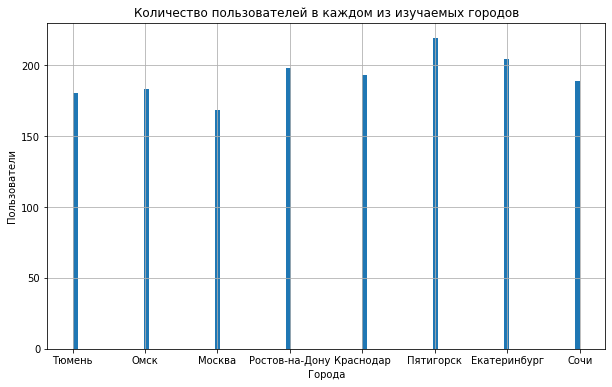

In [ ]:
data_users_go['city'].hist(bins=100, figsize=(10, 6));
plt.title('Количество пользователей в каждом из изучаемых городов')
plt.xlabel('Города')
plt.ylabel('Пользователи');

In [ ]:
freq_of_city = data_users_go['city'].value_counts()
freq_of_city.to_frame(name='Частота встречаемости городов')

,Частота встречаемости городов
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


Изучив, содержащиеся в данных сведения о городах, приходим к **выводу**, что лидером по количеству пользователей является Пятигорск: 219 пользователей, на второй и третьей позициях Екатеринбург и Ростов-на-Дону соответственно, с показателями в 204 и 198 пользователей. Далее города располагаются по нисходящей в следующем порядке: Краснодар - 193 пользователей, Сочи - 189 пользователей, Омск - 183 пользователей, Тюмень - 180 пользователей, Москва - 168 пользователей.

##### Соотношение пользователей с подпиской и без подписки

,,Колличество пользователей с подпиской (ultra) и без подписки (free)
0,ultra,699
1,free,835


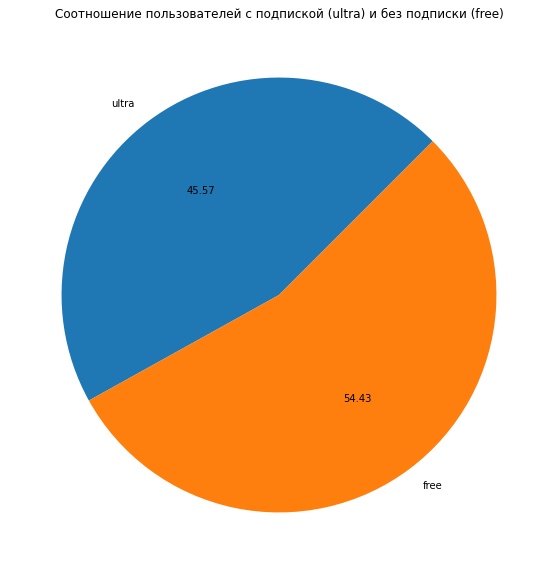

In [ ]:
# Получаем чмсло пользователей с подпиской и без и строим уруговую диаграмму для них
subscription_type = data_users_go['subscription_type'].value_counts(ascending=True)
data_subscription_type = subscription_type.to_frame().reset_index().rename(columns={'index':' ', 'subscription_type':'Колличество пользователей с подпиской (ultra) и без подписки (free)'})
plt.figure(figsize=(10, 10)).add_subplot().pie(data_subscription_type['Колличество пользователей с подпиской (ultra) и без подписки (free)'],
           labels=data_subscription_type[' '], startangle=45, autopct='%.2f');
plt.title('Соотношение пользователей с подпиской (ultra) и без подписки (free)');
data_subscription_type

Изучив, содержащиеся в данных сведения о пользователях с подпиской и без подписки приходим к **выводу**, что большая часть пользователей пользуется самокатами без подписки (54,43%), разрыв составляет 136 пользователей, количество пользователей с подпиской - 699 человек, без подписки - 835 человек.

##### Возраст пользователей

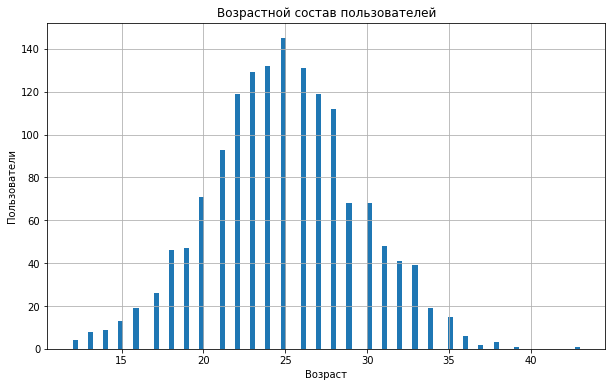

In [ ]:
data_users_go['age'].hist(bins=100, figsize=(10, 6));
plt.title('Возрастной состав пользователей')
plt.xlabel('Возраст')
plt.ylabel('Пользователи');

In [ ]:
data_users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Гистограмма, построенная по сведениям о возрасте пользователей имеет сходство с функцией нормального распределения, представляющей собой непрерывную колоколообразную кривую. Гистгорамма позволяет сделать следующие **выводы:** лидирующем количеством пользователей являются 25-летние - ~145 человек, второе место разделяют 24-х и 26-летние - по ~132 человек, третье место 23-летние - ~130 человек. 22-х, 27 и 28-летние относятся к диапазону ~115-120 человек, 21-летние - ~90 человек, 20, 29 и 30-летние по ~70 человек, 18, 19, 31, 32 и 33-летние - в диапазоне ~40-55 человек, 17-летние - ~25 человек. Прочие возрастные группы имеют каждая менее 20 человек. Самыми малочисленными являются "группы", состоящие из человек старше 36 лет: 37-летнии - 2 человека, 38-летнии - 3 человека, 39 и 43-летние по 1 человеку.

##### Расстояние, которое пользователь преодолел за одну поездку

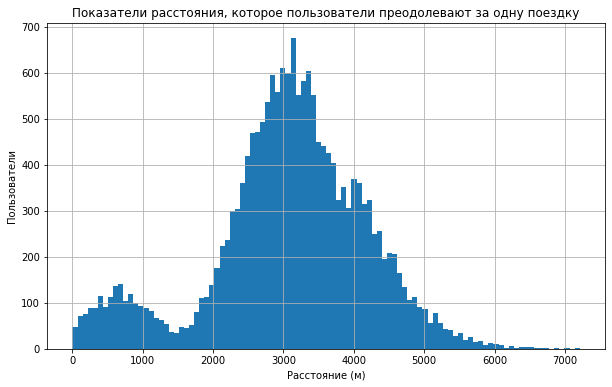

In [ ]:
data_rides_go['distance'].hist(bins=100, figsize=(10, 6));
plt.title('Показатели расстояния, которое пользователи преодолевают за одну поездку')
plt.xlabel('Расстояние (м)')
plt.ylabel('Пользователи');

**Вывод:** гистограмма имеет сравнительно нормальное распределеление с высшей точкой расстояние в ~3200 метров. Всплеск наблюдается также на отметке в 4000 метров, учитывая, что соседние к данному значению точки, соответствующие расстояниям: ~3600-3800 метров и ~4100-4300 расположены на графике ниже. Интересно отметить, что на участке 0-1500 метров тоже наблюдается всплеск. Возможно он обусловлен наличием пользователей, совершающих поездки с целью быстро добраться куда-то на относительно небольшое расстояние.

##### Продолжительность поездок

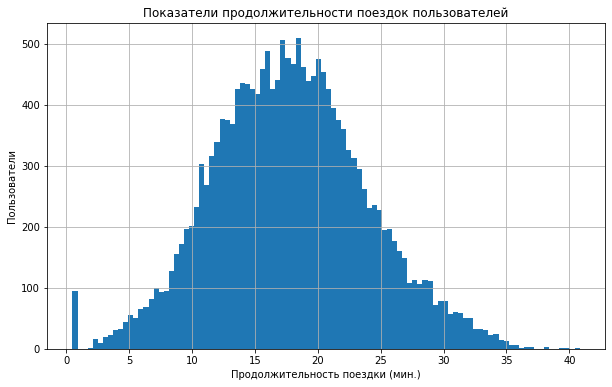

In [ ]:
data_rides_go['duration'].hist(bins=100, figsize=(10, 6));
plt.title('Показатели продолжительности поездок пользователей')
plt.xlabel('Продолжительность поездки (мин.)')
plt.ylabel('Пользователи');

Можем сделать следующие **выводы:** самая популярная продолжительность поездки находится в диапазоне 15-20 минут, менее популярные в диапазонах 10-15 и 20-25 минут. Иные присутствующие в датафрейме значения продолжительности имеют меньшую популярность. целесообразно отметить, что самые долгие поездки продолжаются от 35 до 40 минут, но таких поездок ничтожно мало в сравнении с остальными значениями датафрейма. Вместе с тем ощутимый всплеск количества поездок (почти 100 поездок) находится в значении около одной минуты. Можем предположить, что это поездки длиной в несколько метров до 1500 метров с целью быстро добраться до какого либо места.

#### Шаг 4. Объединение данных

##### Объединяем данные о пользователях, поездках и подписках в один датафрейм

In [ ]:
# Объединяем датафреймы data_users_go, data_rides_go и data_subscriptions_go и сохраняем их в новую переменную
data_go_merge = data_users_go.merge(data_rides_go)
data_go_merge = data_go_merge.merge(data_subscriptions_go)
# Изучаем общие данные о новом датафрейме и смотрим на его первые строки
print(data_go_merge.info())
data_go_merge.head(15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB
None


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


##### Создаем датафреймы c данными о пользователях без подписки и с данными о пользователях с подпиской

In [ ]:
data_go_merge_free = data_go_merge[data_go_merge.subscription_type == 'free']
data_go_merge_ultra = data_go_merge[data_go_merge.subscription_type == 'ultra']
# Изучаем общие данные о двух новых датафреймах
print("""
                              """, 'data_go_merge_free', """
     """)
print(data_go_merge_free.info())
print("""
                             """, 'data_go_merge_ultra', """
     """)
data_go_merge_ultra.info()


                               data_go_merge_free 
     
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
m

##### Визуализируем информацию о расстоянии и времени поездок для пользователей без подписки и с подпиской

###### Расстояние, которое пользователи без подписки преодолевают за одну поездку

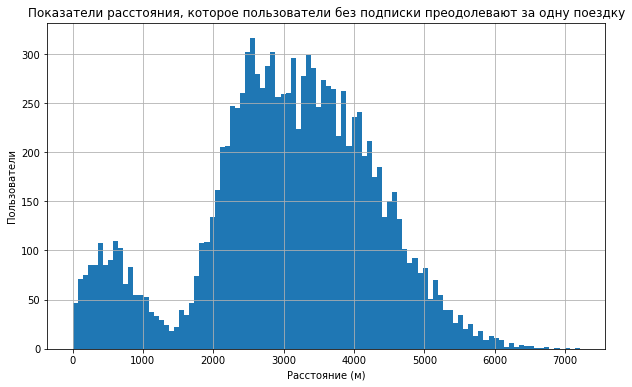

In [ ]:
data_go_merge_free['distance'].hist(bins=100, figsize=(10, 6));
plt.title('Показатели расстояния, которое пользователи без подписки преодолевают за одну поездку')
plt.xlabel('Расстояние (м)')
plt.ylabel('Пользователи');

**Вывод:** самые высокие значения гистограмма принимает на участке, соответствующем расстоянию ~2500-3800 метров. В высшей точке гистограмма соответствует расстоянию в ~2500 метров. Всплеск наблюдается также на участке 0-1500 метров, возможно он обусловлен наличием пользователей, совершающих поездки с целью быстро добраться куда-то на относительно небольшое расстояние. В целом гистограмма максимально похожа на гистограмму, составленную по датафрейму до разделения его на пользователей с подписками и без.

###### Продолжительность поездок пользователей без подписки

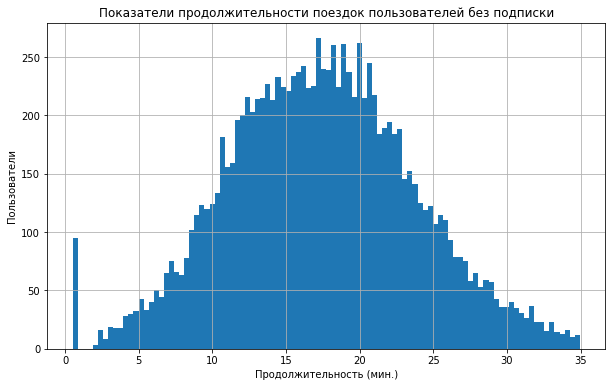

In [ ]:
data_go_merge_free['duration'].hist(bins=100, figsize=(10, 6));
plt.title('Показатели продолжительности поездок пользователей без подписки')
plt.xlabel('Продолжительность (мин.)')
plt.ylabel('Пользователи');

Можем сделать следующие **выводы:** самая популярная продолжительность поездки находится в диапазоне ~17-20 минут, менее популярные в диапазонах 10-17 и 20-23 минут. Иные присутствующие в датафрейме значения продолжительности имеют меньшую популярность. целесообразно отметить, что самые долгие поездки продолжаются в районе 35 минут, но таких поездок немного. Также на данной гистограмме присутствует, наблюдавшийся на гистограмме исходного датафрейма всплеск (почти 100 поездок) в значении около одной минуты.

###### Расстояние, которое пользователи с подпиской преодолевают за одну поездку

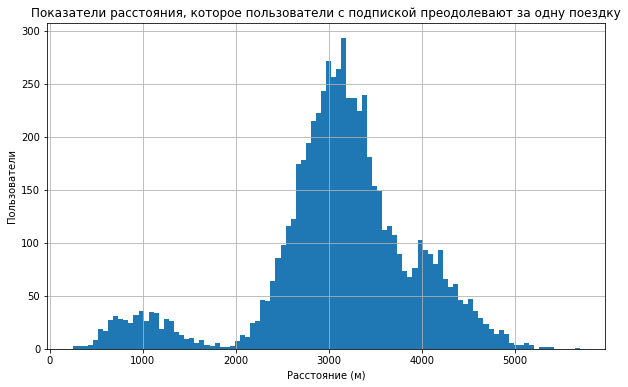

In [ ]:
data_go_merge_ultra['distance'].hist(bins=100, figsize=(10, 6));
plt.title('Показатели расстояния, которое пользователи с подпиской преодолевают за одну поездку')
plt.xlabel('Расстояние (м)')
plt.ylabel('Пользователи');

**Вывод:** данная гистограмма также имеет сходство с гистограммой, составленной по датафрейму до разделения его на пользователей с подписками и без. Данная гистограмма имеет более высокие показатели, чем гистограмма пользователей без подписки, так наивысшая точка соответствует расстоянию в 3200 метров. Как и на гистограмме исходного датафрейма, наблюдается всплеск в районе ~4000-4200 метров. Целесообразно отметить, что всплеск на участке ~1000+-500 метров на данной гистограмме менее выражен, чем на гистограмме пользователей без подписки.

###### Продолжительность поездок пользователей с подпиской

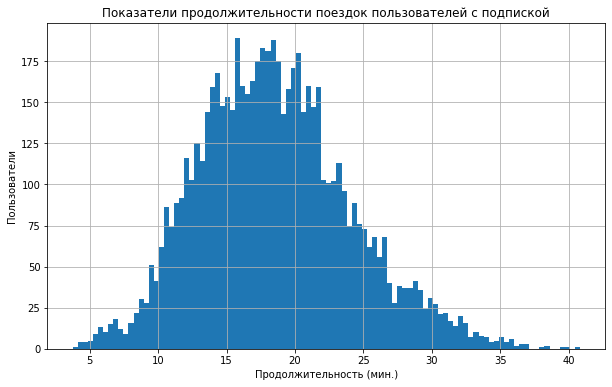

In [ ]:
data_go_merge_ultra['duration'].hist(bins=100, figsize=(10, 6));
plt.title('Показатели продолжительности поездок пользователей с подпиской')
plt.xlabel('Продолжительность (мин.)')
plt.ylabel('Пользователи');

Можем сделать следующие **выводы:** самая популярная продолжительность поездки находится в диапазоне ~17-20 минут, менее популярные в диапазонах 13-17 и 20-23 минут. Иные присутствующие в датафрейме значения продолжительности имеют меньшую популярность. целесообразно отметить, что самые долгие поездки продолжаются в районе 35-40 минут, но таких поездок немного. На данной гистограмме отсутствует, наблюдавшийся на гистограмме исходного датафрейма всплеск в значении около одной минуты. Таким образом, пользователи с подпиской не совершают поездок длительностью меньше минуты.

#### Шаг 5. Подсчёт выручки

##### Создаем датафрейм с агрегированными данными о поездках

In [ ]:
# Округляем продолжительность поездок
data_go_merge['duration'] = np.ceil(data_go_merge['duration'])
# Создаем агрегированный датафрейм
new_data_go_merge = data_go_merge.groupby(['user_id', 'month'] ).agg({'distance':'sum', 'duration':['sum', 'count'],
                                                                      'subscription_type':'first','minute_price':'first',
                                                                      'start_ride_price':'first', 'subscription_fee':'first'})
# Переименовываем столбцы
new_data_go_merge.columns = ['sum_distance', 'sum_duration', 'count_rides', 'subscription_type', 'minute_price',
                             'start_ride_price', 'subscription_fee']
# Ознакамливаемся с агрегированным датафреймом
print(new_data_go_merge.info())
new_data_go_merge

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11331 entries, (1, 1) to (1534, 12)
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sum_distance       11331 non-null  float64
 1   sum_duration       11331 non-null  float64
 2   count_rides        11331 non-null  int64  
 3   subscription_type  11331 non-null  object 
 4   minute_price       11331 non-null  int64  
 5   start_ride_price   11331 non-null  int64  
 6   subscription_fee   11331 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 665.0+ KB
None


sum_distance  sum_duration  count_rides subscription_type  \
user_id month                                                              
1       1       7027.511294          42.0            2             ultra   
        4        754.159807           7.0            1             ultra   
        8       6723.470560          46.0            2             ultra   
        10      5809.911100          32.0            2             ultra   
        11      7003.499363          56.0            3             ultra   
...                     ...           ...          ...               ...   
1534    6       3409.468534          26.0            2              free   
        8       7622.453034          48.0            2              free   
        9       4928.173852          23.0            1              free   
        11     13350.015305          78.0            4              free   
        12      2371.711192          16.0            1              free   

               minute_price  start_ride_price  subscription_fee  
user_id month                                                    
1       1                 6                 0               199  
        4                 6                 0               199  
        8                 6                 0               199  
        10                6                 0               199  
        11                6                 0               199  
...                     ...               ...               ...  
1534    6                 8                50                 0  
        8                 8                50                 0  
        9                 8                50                 0  
        11                8                50                 0  
        12                8                50                 0  

[11331 rows x 7 columns]

*Агрегированный датафрейм создан.*

##### Добавляем в датафрейм столбец с помесячной выручкой, которую принёс каждый пользователь

In [ ]:
# Рассчитываем доход
new_data_go_merge['revenue'] = new_data_go_merge['start_ride_price'] * new_data_go_merge['count_rides'] + new_data_go_merge['minute_price'] * new_data_go_merge['sum_duration'] + new_data_go_merge['subscription_fee']
# Смотрим что получилось
new_data_go_merge

sum_distance  sum_duration  count_rides subscription_type  \
user_id month                                                              
1       1       7027.511294          42.0            2             ultra   
        4        754.159807           7.0            1             ultra   
        8       6723.470560          46.0            2             ultra   
        10      5809.911100          32.0            2             ultra   
        11      7003.499363          56.0            3             ultra   
...                     ...           ...          ...               ...   
1534    6       3409.468534          26.0            2              free   
        8       7622.453034          48.0            2              free   
        9       4928.173852          23.0            1              free   
        11     13350.015305          78.0            4              free   
        12      2371.711192          16.0            1              free   

               minute_price  start_ride_price  subscription_fee  revenue  
user_id month                                                             
1       1                 6                 0               199    451.0  
        4                 6                 0               199    241.0  
        8                 6                 0               199    475.0  
        10                6                 0               199    391.0  
        11                6                 0               199    535.0  
...                     ...               ...               ...      ...  
1534    6                 8                50                 0    308.0  
        8                 8                50                 0    484.0  
        9                 8                50                 0    234.0  
        11                8                50                 0    824.0  
        12                8                50                 0    178.0  

[11331 rows x 8 columns]

*Столбец с помесячной выручкой добавлен*

#### Шаг 6. Проверка гипотез

##### Гипотеза "Тратят ли пользователи с подпиской больше времени на поездки?"

Сформулируем H₀ как "среднии двух генеральных совокупностей равны", а Н1 как "среднее генеральной совокупности данных о времени поездок пользователей с подпиской больше" и проведем статистический тест.

In [ ]:
alpha = 0.01

results = st.ttest_ind(data_go_merge_ultra['duration'], data_go_merge_free['duration'], alternative='greater')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Статистический тест показал, что продолжительности поездки пользователей с подпиской и без неё не равны. Мы обладаем обеими совокупностями и можем рассчитать общую продолжительность поездок для обоих категорий пользователей.

In [ ]:
print('Общая продолжительность поездок пользователей без подписки:', data_go_merge_free['duration'].sum())
print('Общая продолжительность поездок пользователей с подпиской:', data_go_merge_ultra['duration'].sum())

Общая продолжительность поездок пользователей без подписки: 201178.038766945
Общая продолжительность поездок пользователей с подпиской: 120522.90355823789


**Вывод:** *гипотезу "пользователи с подпиской тратят больше времени на поездки" необходимо отбросить, т.к. больше времени на поездки тратят пользователи **без подписки** - на 80000 часов больше.*

##### Гипотеза "Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?"

Сформулируем H₀ как "среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метрам", а Н1 как "среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров".

In [ ]:
interested_value = 3130

alpha =  0.01

results = st.ttest_1samp(data_go_merge_ultra['distance'], interested_value, alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем гипотезу H₀: cреднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не равно', interested_value, 'метрам.')
else:
    print('Отвергаем гипотезу H1: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, менее', interested_value, 'метров.')

p-значение: 0.9195368847849785
Отвергаем гипотезу H1: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, менее 3130 метров.


По результатам проведенного теста гипотеза "среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров" отвергнута. Посмотрим чему равна средняя дистанция поездок указанных пользователей.

In [ ]:
print('Средняя дистанция поездок пользователей с подпиской:', data_go_merge_ultra['distance'].mean())

Средняя дистанция поездок пользователей с подпиской: 3115.4453880370247


**Вывод:** *гипотеза "среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров" отвергнута. Установлено, что средняя дистанция поездок пользователей с подпиской **менее 3130 метров**.

##### Гипотеза "Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?"

Сформулируем H₀ как "среднии двух генеральных совокупностей равны", а Н1 как "среднее генеральной совокупности данных о помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки" и проведем статистический тест.

In [ ]:
# Дополним агрегированный датафрейм сведениями о наличии или отсутствии подписки
new_data_go_merge['subscription_type'] = new_data_go_merge['subscription_type']

alpha = 0.01

results = st.ttest_ind(
    new_data_go_merge.query('subscription_type == "ultra"')['revenue'],
    new_data_go_merge.query('subscription_type == "free"')['revenue'], alternative='greater')

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому мы отвергаем нулевую гипотезу и имеем основания говорить, что пользователи с подпиской тратят в сервисе меньше денег. Рассчитаем фактические траты для обоих категорий пользователей.

In [ ]:
print('Общая выручка с пользователей без подписки:', new_data_go_merge.query('subscription_type == "free"')['revenue'].sum())
print('Общая выручка с пользователей с подпиской:', new_data_go_merge.query('subscription_type == "ultra"')['revenue'].sum())

Общая выручка с пользователей без подписки: 2234104.0
Общая выручка с пользователей с подпиской: 1644537.0


**Вывод:** *гипотезу "помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки" необходимо отбросить. Выручка с пользователей с подпиской" **почти на 600000 меньше** выручки с пользователей без подписки.*

##### Задание на подбор верного теста для проверки гипотезы

Для проверки гипотезы о том, что после обновления серверов количество обращений в техподдержку значимо снизилось необходимо провести тест, проверябщий равны ли средние совокупности до и после этого их изменения - **метод scipy.stats.ttest_rel().**

#### Общий вывод

**В части качества данных**

Данные во всех трёх датафреймах (data_users_go – данные о пользователях, data_rides_go – данные о поездках, data_subscriptions_go – данные о подписках) характеризуются полным отсутствием пропусков и неявных дубликатов. В датафреймах data_rides_go и data_subscriptions_go также отсутствовали строки-дубликаты. В датафрейме data_users_go было выявлено небольшое количество строк-дубликатов (31), ввиду того, что данное количество строк составляет менее 2-х процентов от объема всего датафрейма, указанные строки были удалены из датафрейма.
Была выявлены проблемы с типом данных в столбце 'date' датафрейма data_rides_go, который имел тип данных object, тогда как он должен иметь тип данных дата pandas. Тип данных был скорректирован. Также на этапе предобработки данных датафрейм data_rides_go дополнен столбцом, содержащим сведения о календарном месяце.

**В части изучения отдельных параметров данных:**

*Частота встречаемости городов* \
Сделан вывод о том, что лидером по количеству пользователей является Пятигорск: 219 пользователей, на второй и третьей позициях Екатеринбург и Ростов-на-Дону соответственно, с показателями в 204 и 198 пользователей. Далее города располагаются по нисходящей в следующем порядке: Краснодар - 193 пользователей, Сочи - 189 пользователей, Омск - 183 пользователей, Тюмень - 180 пользователей, Москва - 168 пользователей.

*Соотношение пользователей с подпиской и без подписки* \
Доля пользователях с подпиской составляет 45,57%, без подписки – 54,43%. Таким образом, большая часть пользователей пользуется самокатами без подписки, разрыв составляет 136 пользователей, количество пользователей с подпиской - 699 человек, без подписки - 835 человек.

*Возраст пользователей* \
Лидирующем количеством пользователей являются 25-летние - ~145 человек, второе место разделяют 24-х и 26-летние - по ~132 человек, третье место 23-летние - ~130 человек. 22-х, 27 и 28-летние относятся к диапазону ~115-120 человек, 21-летние - ~90 человек, 20, 29 и 30-летние по ~70 человек, 18, 19, 31, 32 и 33-летние - в диапазоне ~40-55 человек, 17-летние - ~25 человек. Прочие возрастные группы имеют каждая менее 20 человек. Самыми малочисленными являются "группы", состоящие из человек старше 36 лет: 37-летнии - 2 человека, 38-летнии - 3 человека, 39 и 43-летние по 1 человеку.

*Расстояние, которое пользователи преодолевают за одну поездку* \
Самым популярным расстоянием у пользователей является расстояние в ~3200 метров. Всплеск наблюдается также на отметке в 4000 метров, учитывая, что соседние к данному значению точки, соответствующие расстояниям: ~3600-3800 метров и ~4100-4300 расположены на графике ниже. Интересно отметить, что на участке 0-1500 метров также наблюдается всплеск.

*Продолжительность поездок* \
Самая популярная продолжительность поездки находится в диапазоне 15-20 минут, менее популярные в диапазонах 10-15 и 20-25 минут. Иные присутствующие в датафрейме значения продолжительности имеют меньшую популярность. целесообразно отметить, что самые долгие поездки продолжаются от 35 до 40 минут, но таких поездок ничтожно мало в сравнении с остальными значениями датафрейма. Вместе с тем ощутимый всплеск количества поездок (почти 100 поездок) находится в значении около одной минуты.

В целях исследования данных все три датафрейма были объединены в один датафрейм, из которого выделены два новых датафрейма: со всеми данными только о пользователях с подписками и со всеми данными только о пользователях без подписки и изучены следующие параметры:

*Расстояние, которое пользователи без подписки преодолевают за одну поездку* \
Самое популярное расстояние соответствует значениям ~2500-3800 метров. Всплеск наблюдается также на участке 0-1500 метров. В целом результаты максимально похожи на результаты исследования данных до их разделения на пользователей с подписками и без подписок.

*Продолжительность поездок пользователей без подписки* \
Самая популярная продолжительность поездки находится в диапазоне ~17-20 минут, менее популярные в диапазонах 10-17 и 20-23 минут. Самые долгие поездки продолжаются в районе 35 минут, но таких поездок немного. Присутствует, всплеск поездок длительностью около одной минуты, как и в данных, не разделенных по пользователям с подписками и без подписок.

*Расстояние, которое пользователи с подпиской преодолевают за одну поездку* \
Самое популярное расстояние составляет 3200 метров. Как и в данных, не разделенных по пользователям с подписками и без подписок, наблюдается всплеск в значениях расстояния поездок ~4000-4200 метров. Всплеск на участке ~1000+-500 метров в отношении пользователей с подпиской менее выражен, чем в отношении общей совокупности пользователей (с подпиской и без подписки).

*Продолжительность поездок пользователей с подпиской* \
Самая популярная продолжительность поездки находится в диапазоне ~17-20 минут, менее популярные в диапазонах 13-17 и 20-23 минут. Целесообразно отметить, что самые долгие поездки продолжаются в районе 35-40 минут, но таких поездок немного. В данных о пользователях с подпиской отсутствует, наблюдавшийся в данных об общей совокупности пользователей (с подпиской и без подписки) всплеск поездок в значении длительности около одной минуты: пользователи с подпиской не совершают поездок длительностью меньше минуты.

В целях проверки гипотез создан датафрейм с агрегированными данными о поездках, содержащий суммарное расстояние, количество поездок, суммарное время и выручку для каждого пользователя за каждый месяц.

**В части проверкт гипотез:**

*"Тратят ли пользователи с подпиской больше времени на поездки?"* \
Гипотезу "пользователи с подпиской тратят больше времени на поездки" была отброшена по результатам статистического теста, так как выяснилось, что больше времени на поездки тратят пользователи без подписки - на 80000 часов больше.

*"Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?"* \
С целью проверки гипотезы была сформулирована альтернативная гипотеза: "среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров". Данная гипотеза была отвергнута по результатам статистического теста. Установлено, что средняя дистанция поездок пользователей с подпиской менее 3130 метров. Стоит отметить, что указанная длительность поездки удовлетворяет предпочтения компании в части оптимального времени поездки пользователей, так как она благоприятно сказывается на сроке службы самокатов.

*"Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?"* \
По результатам статистического теста гипотеза "помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки" была отброшена: выручка с пользователей с подпиской" почти на 600000 меньше, чем выручка с пользователей без подписки.

**Итог:** результаты проверки вышеперечисленных гипотез не позволяет говорить о том, что пользователи с подпиской более выгодны для компании, чем пользователи без подписки. Больше времени на поездки тратят и приносят больше денег пользователи, не имеющие подписки. Соответственно, более выгодны для компании пользователи без подписки.
